In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)

In [3]:
from causalgraphicalmodels import CausalGraphicalModel
import daft

# 8. Conditional Manetees

The examples of A.W.38 and manatee injuries: the evidence misleads us because it's **conditional** on survival.

**Conditioning**
- Data are conditional on how they get into our sample.
- Posterior distributions are conditional on the data.
- All model-based inference is conditional on the model.
- **Every inference is conditional on something, whether we notice it or not.**

The power of statistical modeling comes from **creating devices that allow probability to be conditional of aspects of each case.**

Simple linear models often fail to provide enouch conditioning. Thus, to model deeper conditonality (i.e., *where the importance of one predictor depends on another predictor*), we need **interaction** (aka **moderation**).
- Interactions are central to most statistical models beyond the cozy world of Gaussian outcomes and linear models of the mean.
- *In GLMs, even when one doesn not explicitly define variables as interacting, they will alwyas interact to some degree. (Ch. 10)*

Models with complex interactions are harder to understand. How to specify, interpret, and plot them matters. **Interactions are common, but they are not easy.**

## 8.1. Building an interaction

>Puzzle: Bad africa tends to be related to bad economics outside of Africa, but African economies may actually benefit from bad geography.

**Regression of terrain ruggedness against economic performace (log GDP per capita in 2000), both inside and outside of Africa.**
- `rugged`; Terrain Ruggedness Index (topographic heterogeneity of a landscape)
- `rgdppc_2000`: Log GDP (log because it's magnitude)

**Causal hypothesis on the regression**
- R: ruggedness
- G: GDP
- C: continent

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


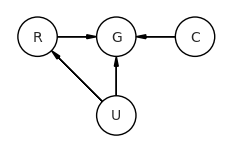

In [4]:
africa_dag = CausalGraphicalModel(
    nodes=["R", "G", 'C', "U"], 
    edges=[("R", "G"), ("C", "G"), ('U', 'G'), ("U", "R")]
)
pgm = daft.PGM()
coordinates = {
    "R": (0, 0), 
    "G": (1, 0), 
    "C": (2, 0), 
    "U": (1, -1)
}
for node in africa_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in africa_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render();

This DAG doesn't display an interaction. How to create a model that produces the conditionability? We could cheat by *splitting* the data into two data frames, one for Africa and one for all the other contintnes. But **it is never a good idea to split the data in this way. Four reasons:**

**1. There are usually some parameters, such as $\sigma$, that the model ays do not depend in any way upon continent.**
- By splitting the data table, we're hurting the accuracy of the estimates for these parameters, because we're making **two less-accurate estimaes** instead of pooling all of the evidence into one estimate. 
- We also accidentally **assume that variance differs** between African and non-African nations. The assumption itself is okay but **we need to avoid accidental assumptions.**

**2. To acquire probability statements about the variable we used to split the data,we need to include it in the model.** Otherwise, we get a weak statistical argument.

**3. We may want to use information criteria or another method to compare models.** To compare a model that treats all continents the same way to a model that allows different slops in different continents, we need models that us all of the same data.

**4. There are advantages of borrowing information across categories.** This is especially true when sample sizes vary across categories, such that overfitting risk is higher within some categories. E.g., what we learn about ruggedness outside of Africa should have some effect on our estimate within Africa, and vice versa. 

### 8.1.1. Making a rugged model

#### Code 8.1. Prepared the data for modeling

In [5]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

#### Fig. 8.2. Separate linear regressions inside and outside of Africa, for log GDP against terrain ruggedness.

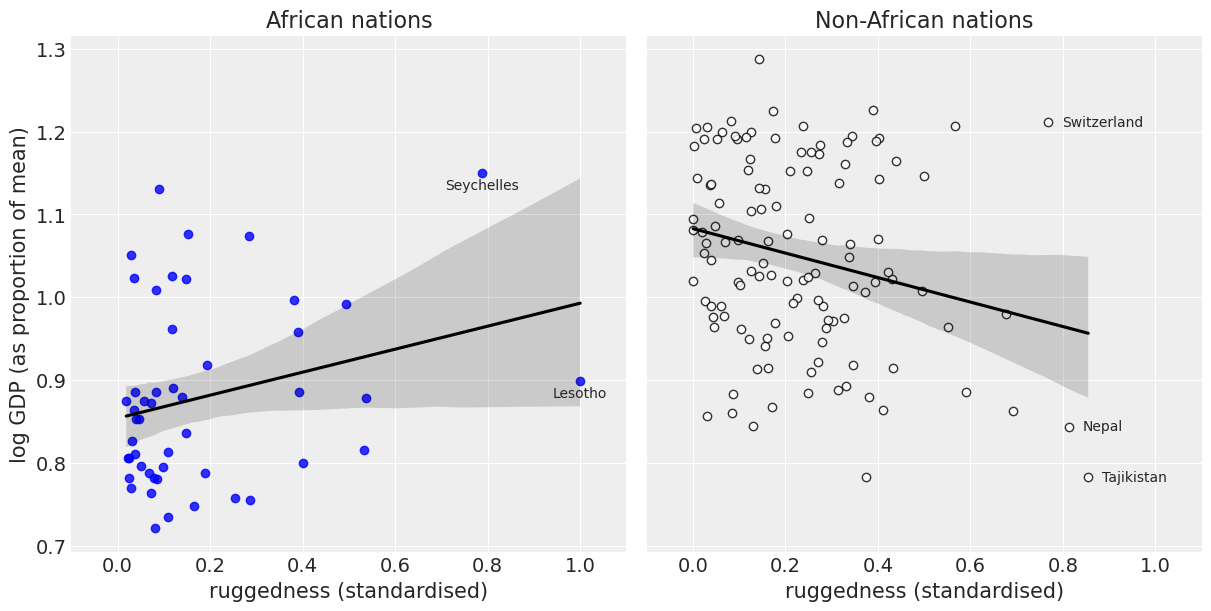

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.regplot(
    dd.loc[dd["cont_africa"] == 1]["rugged_std"],
    dd.loc[dd["cont_africa"] == 1]["log_gdp_std"],
    scatter_kws={"color": "b"},
    line_kws={"color": "k"},
    ax=axs[0],
)
sns.regplot(
    dd.loc[dd["cont_africa"] == 0]["rugged_std"],
    dd.loc[dd["cont_africa"] == 0]["log_gdp_std"],
    scatter_kws={"edgecolor": "k", "facecolor": "w"},
    line_kws={"color": "k"},
    ax=axs[1],
)

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

# label countries
for _, africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 1)].iterrows():
    axs[0].text(
        africa["rugged_std"],
        africa["log_gdp_std"] - 0.02,
        africa["country"],
        ha="center",
    )

for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["log_gdp_std"],
        non_africa["country"],
        va="center",
    )

for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

#### Code 8.2. Bayesian model for the regression

$$\log(y_{i}) \sim \text{Normal}(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta(r_{i}-\bar{r})$$

$y_{i}$: GDP for a nation, $r$: ruggedness, $\bar{r}$: average ruggedness in the whole sample

In [7]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

#### Code 8.3. Specifying priors

In [8]:
with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive()

# Figure 8.3 is below

#### Code 8.4

In [9]:
np.sum(np.abs(m_8_1_prior["b"]) > 0.6) / len(m_8_1_prior["b"])

0.516

#### Code 8.5. Model with tightened priors

In [10]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


#### Figure 8.3. Simulating in search of reasonable priors for the terrain ruggedness example.

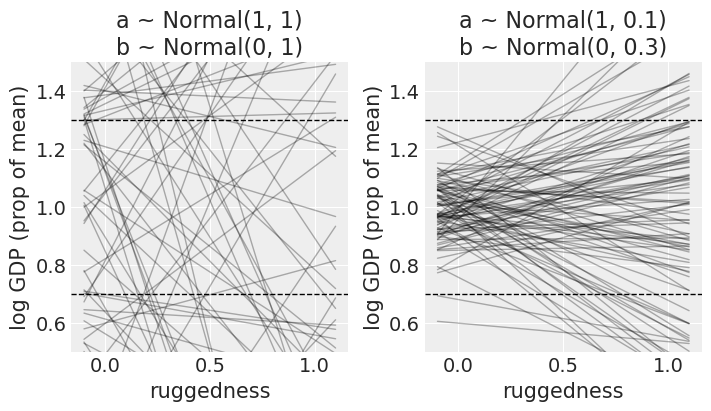

In [11]:
# Figure 8.3

_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1)
ax1.plot(
    rugged_plot,
    m_8_1_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

ax2.plot(
    rugged_plot,
    m_8_1t_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1t_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

#### Code 8.6. Posterior of the new model

In [12]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.08,0.09
sigma,0.14,0.01,0.13,0.15


### 8.1.2. Adding an indicator variable isn't enough
To build a model that allows nations inside and outside Africa to have different intercepts, we could add another term to th elinear model:
$$\mu_{i} = \alpha + \beta(r_{i}-\bar{r}) + \gamma A_{i}$$

where $A_{i}$ is `conf_africa`, a 0/1 indicator variable. But this is usually a bad idea. The problem is that **we need a prior for $\gamma$**. We can set a prior but *what that prior will necessarily do is tell the model that $\mu_{i}$ for a nation in Africa is more uncertain, before seeing the data, than $\mu_{i}$ outside Africa, which doesn't make sense*. Instead, we can use an index variable:
$$\mu_{i} = \alpha_{\text{CID}[i]} + \beta(r_{i}-\bar{r})$$

CID is an index variable, continental ID (1 for Africa, 2 for all other nations). This means we have two parameters, $\alpha_{1}$ and $\alpha_{2}$. With this approach, we can **reuse the same prior** for the two groups. **Structurally, this is the same as the previous model, but assigning prior this way is more sensible.**

#### Code 8.7: Creatign an index variable showing inside/outside Africa

In [13]:
cid = pd.Categorical(dd["cont_africa"])

#### Code 8.8: A new model with an index variable
Note that we can simply use `a[cid]` to indicate the index.

In [14]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[cid] + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


#### Code 8.9: Model comparison w/ WAIC (with vs. without the continent)

In [15]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace})

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:1406: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_2,0,-252.233141,4.190498,0.000000,0.967382,14.887297,0.000000,True,deviance
m_8_1t,1,-188.876126,2.555783,63.357016,0.032618,12.916565,14.702684,False,deviance


`d_waic` is still much larger than `dse`, thus `m_8_2` (the model w/ continent ID) seems to be picking up some important association in the sample.

#### Code 8.10: Inspecting the marginal posterior distributions

In [16]:
az.summary(m_8_2_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.85,0.90
b,-0.05,0.05,-0.13,0.02
sigma,0.11,0.01,0.10,0.12


`a[1]` (African nations) seems to be reliably lower than `a[0]`.

#### Code 8.11: Posterior contrast between the two intercepts

In [17]:
with m_8_2:
    m_8_2_posterior = pm.sample_posterior_predictive(m_8_2_trace, var_names=['a', 'b', 'sigma']) # getting all for 8.12

diff_a0_a1 = m_8_2_posterior["a"][:, 1] - m_8_2_posterior["a"][:, 0]

az.hdi(diff_a0_a1)

array([-0.20071132, -0.13986847])

The difference is reliably below zero.

#### Code 8.12: Plotting the posterior predictions

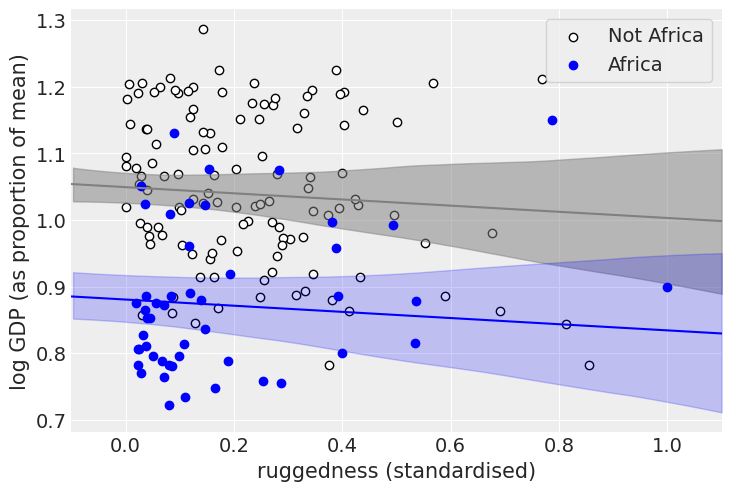

In [18]:
fig, ax = plt.subplots()

rugged_seq = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)

pred0 = m_8_2_posterior["a"][:, 0] + rugged_seq.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_seq, pred0.mean(1), color="grey")
az.plot_hdi(rugged_seq, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = m_8_2_posterior["a"][:, 1] + rugged_seq.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_seq, pred1.mean(1), color="b")
az.plot_hdi(rugged_seq, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");

This shows that there's a **rather weak negative relationship between GDP and ruggedness.** All including a dummy variable for African nations has done is **allow the model to predict a lower mean for African nations. It can't do anything to the slop of the line.** The fact that **WAIC tells you that the model with the dummy variable is hugely better only indicates that African nations on average do have lower GDP.**

### 8.1.3. Adding an interaction does work.
Simply we need an model where the slope is also conditional on continent.
$$\mu_{i} = \alpha_{\text{CID}[i]} + \beta_{\text{CID}[i]} (r_{i}-\bar{r})$$

We could use an indicator approach but that introduces a new variable ($\gamma$) and setting prior is difficult.

#### Code 8.13: The model with an interaction (slope conditional on CID)

In [19]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


#### Code 8.14: Inspecting the marginal posterior distributions

In [20]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.04,1.07
a[1],0.89,0.02,0.86,0.92
b[0],-0.14,0.06,-0.22,-0.05
b[1],0.13,0.07,0.02,0.25
sigma,0.11,0.01,0.10,0.12


Now the slope `b[0]` is negative.

#### Code 8.15: Model comparison (PSIS, `loo`)

In [21]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="loo")

/Users/honshi01/anaconda3/envs/stat-rethink2-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_3,0,-259.404168,4.842513,0.000000,0.882218,14.567079,0.000000,False,deviance
m_8_2,1,-252.218474,4.197832,7.185694,0.117782,14.890227,6.527954,False,deviance
m_8_1t,2,-188.869886,2.558903,70.534282,0.000000,12.917046,14.812682,False,deviance


- `m_8_3` has a very high weight (strong support for including the interaction)
- However, some weight goes to `m_8_2`; meaning that `m_8_3` might be a little overfit.
- Also, `d_loo` between `m_8_2` and `m_8_3` is similar to `dse`

#### Code 8.16: PSIS Pareto k values

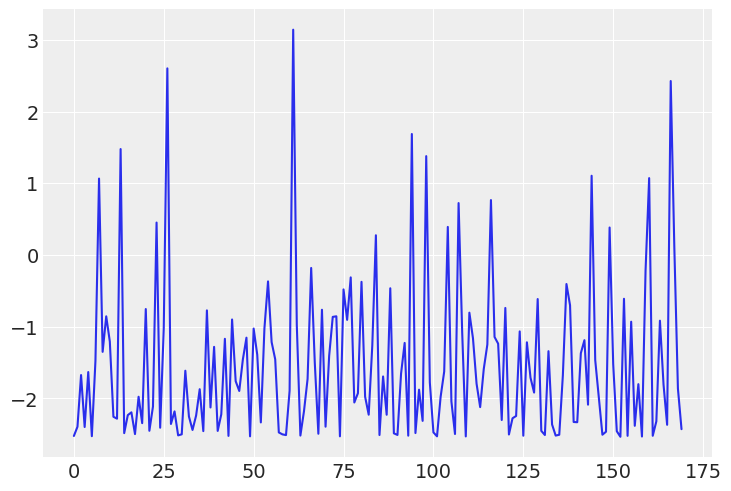

In [22]:
m_8_3_loo = az.loo(m_8_3_trace, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

Some countires have very high k (they are highly influential). Note that this model comparison doesn't tell us about causal inference (it's about how important features are for prediction).

### 8.1.4. Plotting the interaction.

#### Code 8.17

In [23]:
with m_8_3:
    m_8_3_posterior = pm.sample_posterior_predictive(m_8_3_trace, var_names=["a", "b"])

Text(0, 0.5, 'log GDP (as proportion of mean)')

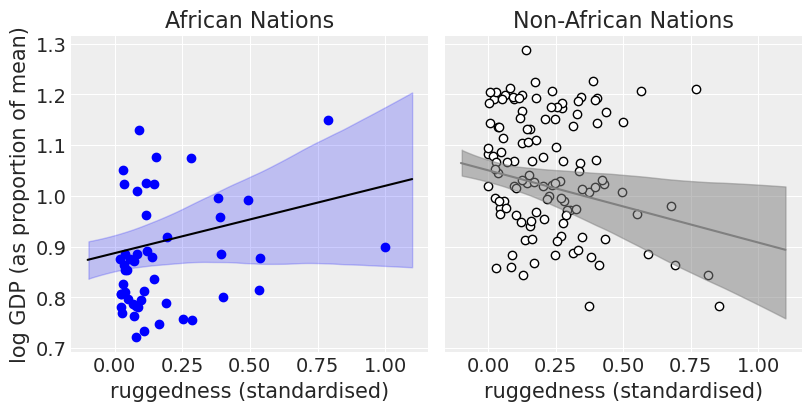

In [24]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred0 = m_8_3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 0]
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred1 = m_8_3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 1]
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")

## 8.2. Symmetry of interactions
Interactions are like [Buridan's ass](https://en.wikipedia.org/wiki/Buridan%27s_ass). A simple interaction model contains **two symmetrical interpretations.**

Africa vs. GDP example: the interaction here has two equally valid phrasings.
1. How much does the associationg btw ruggedness and log GDP depend on whether the nation is in Africa?
2. How much does the association of Africa with log GDP depend on ruggedness?

Sounds different to us but for the model, there's no distinction.

#### Code 8.18: Compute the difference between a nation in Africa and outside Africa, holding its ruggedness constant
Reminder:
```python
pred0 = m_8_3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 0]
pred1 = m_8_3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 1]
```

(0.0, 1.0)

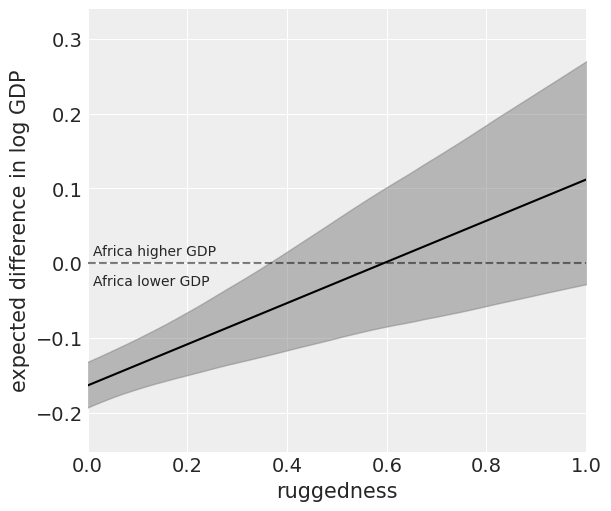

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_seq = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_seq, delta.mean(1), c="k")
az.plot_hdi(rugged_seq, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference in log GDP")
ax.set_xlim(0, 1)

**How to interpret this plot**
- This plot is **counter-factual.** There's no raw data here (because it's **posterior predictive samples**).
- y axis: expected difference in log GDP between nations inside and outside Africa. 0 means no difference between the two groups.
    - Below the horizontal line: African nations have lower expected GDP (case for most terrain ruggedness values)
- At the highest ruggedness values
    - a nation is possibly better off *inside Africa than outside it* because the mean difference is positive.
    - hard to find any reliable difference inside and outside Africa because the uncertainty is high.
- At the lower ruggedness values (smooth nations)
    - being in Africa is a liability for the economy because the difference is negative and it's pretty certain.

(0.0, 1.0)

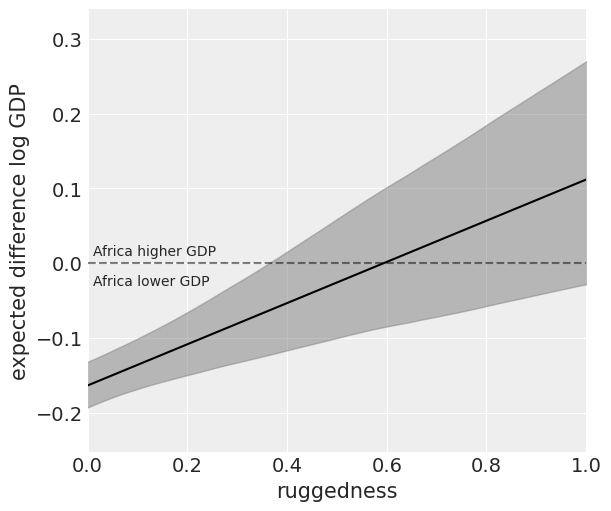

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_seq = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_seq, delta.mean(1), c="k")
az.plot_hdi(rugged_seq, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)

## 8.3. Continuous interactions

Interaction effects are difficult to interpret. Continuous interactions are even more difficult. **Visualization helps.**

### 8.3.1. A winter flower

Data: sizes of blooms for beds of tulips grown in green houses, under different soil and light conditions.

#### Code 8.19: Loading the tulip data

In [27]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


- `blooms`: outcome
- `water` and `shade`: predictor
    - `water`: 3 ordered levels of soil moisture (low 1 to high 3)
    - `shade`: 3 ordered levels of ligh exposure (high 1 to low 3)
- `bed`: labels for which section of greenhouse they are from

### 8.3.2. The models

Comparing the two models:
1. No interaction
2. Interaction between `water` and `shade`

Causal scenario: water (W) and shade (S) both influence blooms (B) (W -> B <- S). But this DAG doesn't tell us the function, $B=f(W, S)$.

#### Model 1: Main effects only

$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S})$$

#### Code 8.20: Scaling the data
Why scaling `bloom` with its max
1. Large values can make optimization difficult.
2. Easy to assign reasonable priors this way.
3. 0 is a meaningful boundary

In [28]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

**Setting the priors**

$$\alpha \sim \text{Normal}(0.5, 1)$$
$$\beta_W \sim \text{Normal}(0, 1)$$
$$\beta_S \sim \text{Normal}(0, 1)$$

- $\alpha$: centering at 0.5 means that the model expects blooms to be halfway to the observed maximum when both water and shade are at their mean.
- The other two centered at 0, meaning no prior information about direction.
- The prior std values are all 1, which is too broad.

#### Code 8.21: Estimating the prior std of $\alpha$
$\alpha$ should be larger than 0 and less than 1 (we normalized this way). But this prior assigns most of probability outside that range:

In [29]:
a = stats.norm.rvs(0.5, 1, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.6261

#### Code 8.22: Using a more stricter prior for $\alpha$

In [30]:
a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.0434

Same thing goes for the slopes
- First, the range of both predictors is 2 (-1 to 1).
- The theoretical minimum of 0 (min) blooms to 1 (max blooms), the range is 1.
- **If we assign std of 0.25 for both slopes, 95% of prior are from -0.5 to 0.5** (range of 1).

#### Code 8.23: Building the main-effects-only model

In [31]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_4_trace = pm.sample()
    m_8_4_post = pm.sample_posterior_predictive(m_8_4_trace, var_names=["a", "bw", "bs"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


#### Model 2: Interaction model
Idea: we want the slope of water conditional on shade and vice versa.

$$B_i \sim Normal(\mu_i,\sigma)$$

$$\mu_i=\alpha+\beta_W(W_i−\overline{W})+\beta_S(S_i−\overline{S}) +\beta_{WS}W_iS_i $$

Setting the prior for $\beta_{WS}$ is hard because it doesn't have a clear natural meaning. Still, *implied predictions* help. Here, setting the std the same as other slopes.

#### Code 8.24: Building the interaction model

In [32]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"] + bws * d["water_cent"] * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_5_trace = pm.sample()
    m_8_5_post = pm.sample_posterior_predictive(m_8_5_trace, var_names=["a", "bw", "bs", "bws"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


In [33]:
az.summary(m_8_5_trace)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.359,0.028,0.317,0.407,0.001,0.000,2683.0,1602.0,1.0
bw,0.206,0.034,0.149,0.258,0.001,0.001,1878.0,1112.0,1.0
bs,-0.114,0.036,-0.168,-0.057,0.001,0.001,1755.0,1517.0,1.0
bws,-0.143,0.042,-0.212,-0.080,0.001,0.001,2116.0,1529.0,1.0
sigma,0.144,0.023,0.109,0.176,0.001,0.000,1946.0,1398.0,1.0


`bws` is negative but it's difficult to understand what this means.

### 8.3.3. Plotting posterior predictions
**Triptych** plots are very handy for understanding the impact of interactons.
- Each plot is a bivariate relationship.
- Left: low value, middle: median, right: high value

#### Code 8.25: Comparing the two models in terms of posterior predictions

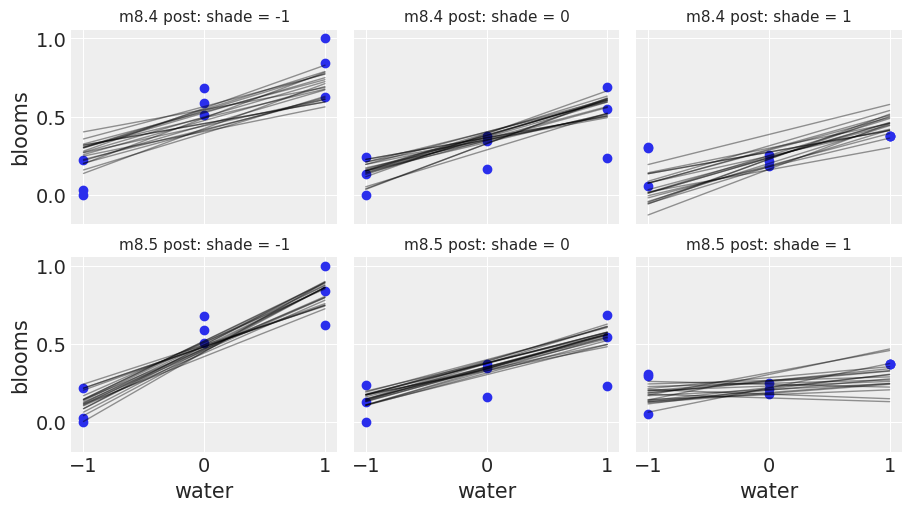

In [36]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_post["a"][:n_lines]
        + m_8_4_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_post["a"][:n_lines]
        + m_8_5_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"][:n_lines] * shade
        + m_8_5_post["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water");

- Top: main-effect model
    - Water helps (positive slope) but shade hurts (intercepts sink w/ higher shade).
    - **The slope w/ water doesn't vary across shade levels.** Without the interaction, it cannot vary.
- Bottom: interaction model 
    - The effect of water decreases as shade increases (line gets flatter in high shade).

### 8.3.4. Plotting prior predictions

#### Code 8.26: Simulating and plotting prior predictions

In [37]:
with m_8_4:
    m_8_4_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])

with m_8_5:
    m_8_5_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])

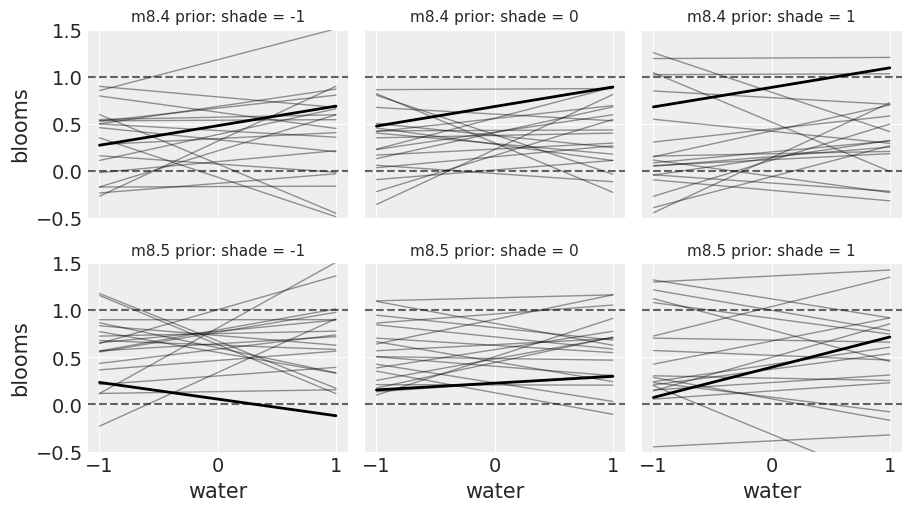

In [38]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_priors["a"][:n_lines]
        + m_8_4_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_4_priors["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_priors["a"][:n_lines]
        + m_8_5_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_5_priors["bs"][:n_lines] * shade
        + m_8_5_priors["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water");

The bold lines are not the mean but just a sample. This is to show whether slopes can vary across shade: top, they can't because there's no interaction, but bottom, it's possible.

## 8.4. Summary
- **You can't see interactions in a DAG!**
- But they are important for accurate inferences.
- Interactions can be difficult to interpret, and so *triptych* plots can be useful.

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas  1.0.5
numpy   1.18.5
seaborn 0.10.1
arviz   0.10.0
pymc3   3.9.3
last updated: Mon Oct 19 2020 

CPython 3.8.3
IPython 7.16.1
watermark 2.0.2
